####1. Install dependencies

In [1]:
# Install dependencies
!pip install -q monai nibabel matplotlib medpy

import torch, os, numpy as np, nibabel as nib
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import UNet
from medpy.metric.binary import dc, hd95
import time
import pandas as pd
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 20.4 MB/s eta 0:00:00


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [2]:
# Device setup for Colab (CUDA) or local Mac (MPS) or fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_type = f"CUDA ({torch.cuda.get_device_name(0)})"
    print(f"Using GPU: {gpu_type}")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    gpu_type = "MPS (Apple Silicon)"
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    gpu_type = "CPU"
    print("Using CPU")

Using GPU: CUDA (Tesla T4)


####2. Downloading dataset

In [4]:
!pip install wldhx.yadisk-direct
!yadisk-direct https://disk.360.yandex.ru/d/QQdaR-pM-el2fQ > direct_link.txt
!cat direct_link.txt
!wget -O test_unet.zip "$(cat direct_link.txt)"

https://downloader.disk.yandex.ru/disk/2dbfa7376f95b8d3d4f987156cd8de44f36c192f7c5ed61b5295d1bd12dbc478/694d9664/fKqInKw3d7bLFOeFnMGnhNIGs5DDc9RQnVq00lapsFEwkoXGLQnvjURiQSMctg_Rnxudmx7nANXqWW6RNxaQnk6XqloTiU-TmDE0biD8FAur8npumZHI4midPdWhecNq?uid=0&filename=test_unet.zip&disposition=attachment&hash=qYuqGhpuYwmtwBRSCijFDDV98LLyaI4ABlTs5pKpd9/o9IglbBQmsTdD2cdY/44dtFP6gwbjvtaafTptcua4SA%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=1130000067809040&fsize=1325571601&hid=02a593d672133943aa7c7e9044bd4387&media_type=compressed&tknv=v3
--2025-12-25 15:54:13--  https://downloader.disk.yandex.ru/disk/2dbfa7376f95b8d3d4f987156cd8de44f36c192f7c5ed61b5295d1bd12dbc478/694d9664/fKqInKw3d7bLFOeFnMGnhNIGs5DDc9RQnVq00lapsFEwkoXGLQnvjURiQSMctg_Rnxudmx7nANXqWW6RNxaQnk6XqloTiU-TmDE0biD8FAur8npumZHI4midPdWhecNq?uid=0&filename=test_unet.zip&disposition=attachment&hash=qYuqGhpuYwmtwBRSCijFDDV98LLyaI4ABlTs5pKpd9/o9IglbBQmsTdD2cdY/44dtFP6gwbjvtaafTptcua4SA%3D%3D%3A&limit=0&content_type=application%2F

In [5]:
!unzip '/content/test_unet.zip'

Archive:  /content/test_unet.zip
   creating: test_gt/
  inflating: __MACOSX/._test_gt      
  inflating: test_gt/.DS_Store       
  inflating: __MACOSX/test_gt/._.DS_Store  
  inflating: test_gt/unet_2d_best.pth  
  inflating: __MACOSX/test_gt/._unet_2d_best.pth  
   creating: test_gt/imagesTs/
  inflating: __MACOSX/test_gt/._imagesTs  
   creating: test_gt/gt_labels/
  inflating: __MACOSX/test_gt/._gt_labels  
  inflating: test_gt/imagesTs/BraTS_0431_0002.nii.gz  
  inflating: __MACOSX/test_gt/imagesTs/._BraTS_0431_0002.nii.gz  
  inflating: test_gt/imagesTs/BraTS_0020_0003.nii.gz  
  inflating: __MACOSX/test_gt/imagesTs/._BraTS_0020_0003.nii.gz  
  inflating: test_gt/imagesTs/BraTS_0956_0003.nii.gz  
  inflating: __MACOSX/test_gt/imagesTs/._BraTS_0956_0003.nii.gz  
  inflating: test_gt/imagesTs/BraTS_0111_0002.nii.gz  
  inflating: __MACOSX/test_gt/imagesTs/._BraTS_0111_0002.nii.gz  
  inflating: test_gt/imagesTs/BraTS_0608_0002.nii.gz  
  inflating: __MACOSX/test_gt/imagesTs/._BraT

####3. Model setup

In [3]:
# Model setup (same as training)
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

In [6]:
# Load weights
weights_path = "/content/test_gt/unet_2d_best.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [16]:
# Folders
TEST_IMG_DIR = "/content/test_gt/imagesTs"
GT_DIR = "/content/test_gt/gt_labels"

# Get cases
# Get unique case IDs from filenames
all_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.nii.gz')]
case_ids = sorted(set(f.split('_0003.nii.gz')[0] for f in all_files if '_0003.nii.gz' in f))
print(f"Found {len(case_ids)} test cases")

Found 125 test cases


In [17]:
# Metrics storage
dice_scores = []
inference_times = []

####4. Testing

In [23]:
for case_id in case_ids:
    flair_path = os.path.join(TEST_IMG_DIR, f"{case_id}_0003.nii.gz")
    gt_path = os.path.join(GT_DIR, f"{case_id}.nii.gz")

    if not os.path.exists(flair_path):
        print(f"Missing FLAIR: {case_id}")
        continue
    if not os.path.exists(gt_path):
        print(f"Missing GT: {case_id} — skipping metrics")
        continue

    # Load FLAIR
    flair_nii = nib.load(flair_path)
    flair = flair_nii.get_fdata().astype(np.float32)

    # Load GT
    gt_nii = nib.load(gt_path)
    gt = gt_nii.get_fdata().astype(np.uint8)

    # Voxel spacing from GT header
    voxel_spacing = gt_nii.header.get_zooms()[:3]

    start_time = time.time()

    # Predict slice-by-slice
    pred_volume = np.zeros_like(flair, dtype=np.uint8)
    with torch.no_grad():
        for z in range(flair.shape[2]):
            slice_img = flair[:, :, z]
            slice_norm = (slice_img - slice_img.mean()) / (slice_img.std() + 1e-8)
            input_tensor = torch.from_numpy(slice_norm).unsqueeze(0).unsqueeze(0).float().to(device)

            output = model(input_tensor)
            pred_slice = (torch.sigmoid(output) > 0.5).cpu().numpy().astype(np.uint8).squeeze()
            pred_volume[:, :, z] = pred_slice

    inf_time = time.time() - start_time
    inference_times.append(inf_time)

    # Save prediction
    pred_nii = nib.Nifti1Image(pred_volume, flair_nii.affine, flair_nii.header)
    os.makedirs("/content/test_preds_flair_only", exist_ok=True)
    nib.save(pred_nii, f"/content/test_preds_flair_only/{case_id}.nii.gz")

    # Whole Tumor (WT = labels 1,2,3)
    gt_wt = (gt > 0).astype(np.uint8)        # Tumor = 1, Background = 0
    pred_wt = (pred_volume > 0).astype(np.uint8)

    if gt_wt.sum() == 0 and pred_wt.sum() == 0:
        dice = 1.0
    elif gt_wt.sum() == 0:
        dice = 0.0
    else:
        if pred_wt.sum() == 0:
            dice = 0.0
        else:
            dice = dc(pred_wt, gt_wt)

    dice_scores.append(dice)
    hd95_scores.append(hd)

    print(f"{case_id}: Whole Tumor Dice = {dice:.4f}, Time = {inf_time:.2f}s")

# Summary
mean_dice = np.mean(dice_scores)
mean_time = np.mean(inference_times)

summary_df = pd.DataFrame([{
    'Method': 'Baseline U-Net 2D (FLAIR only)',
    'Mean Dice (Whole Tumor)': f"{mean_dice:.4f}",
    'GPU': gpu_type,
    'Avg. time per case': f"{mean_time:.2f} s",
}])

print("\n Summary (Whole Tumor On Flair) ")
print(summary_df.to_string(index=False))

# Save
summary_df.to_csv('/content/flair_unet_whole_tumor_summary.csv', index=False)

BraTS_0010: Whole Tumor Dice = 0.8008, Time = 0.69s
BraTS_0020: Whole Tumor Dice = 0.6562, Time = 0.66s
BraTS_0030: Whole Tumor Dice = 0.7310, Time = 0.66s
BraTS_0036: Whole Tumor Dice = 0.7200, Time = 0.63s
BraTS_0043: Whole Tumor Dice = 0.6668, Time = 0.62s
BraTS_0045: Whole Tumor Dice = 0.9270, Time = 0.66s
BraTS_0060: Whole Tumor Dice = 0.9153, Time = 0.65s
BraTS_0069: Whole Tumor Dice = 0.9100, Time = 0.65s
BraTS_0077: Whole Tumor Dice = 0.8560, Time = 0.65s
BraTS_0080: Whole Tumor Dice = 0.8846, Time = 0.66s
BraTS_0082: Whole Tumor Dice = 0.8467, Time = 0.71s
BraTS_0083: Whole Tumor Dice = 0.9324, Time = 0.84s
BraTS_0100: Whole Tumor Dice = 0.9033, Time = 0.81s
BraTS_0111: Whole Tumor Dice = 0.8546, Time = 0.66s
BraTS_0116: Whole Tumor Dice = 0.9449, Time = 0.62s
BraTS_0123: Whole Tumor Dice = 0.7810, Time = 0.63s
BraTS_0127: Whole Tumor Dice = 0.9423, Time = 0.64s
BraTS_0129: Whole Tumor Dice = 0.9491, Time = 0.64s
BraTS_0130: Whole Tumor Dice = 0.9192, Time = 0.65s
BraTS_0134: 

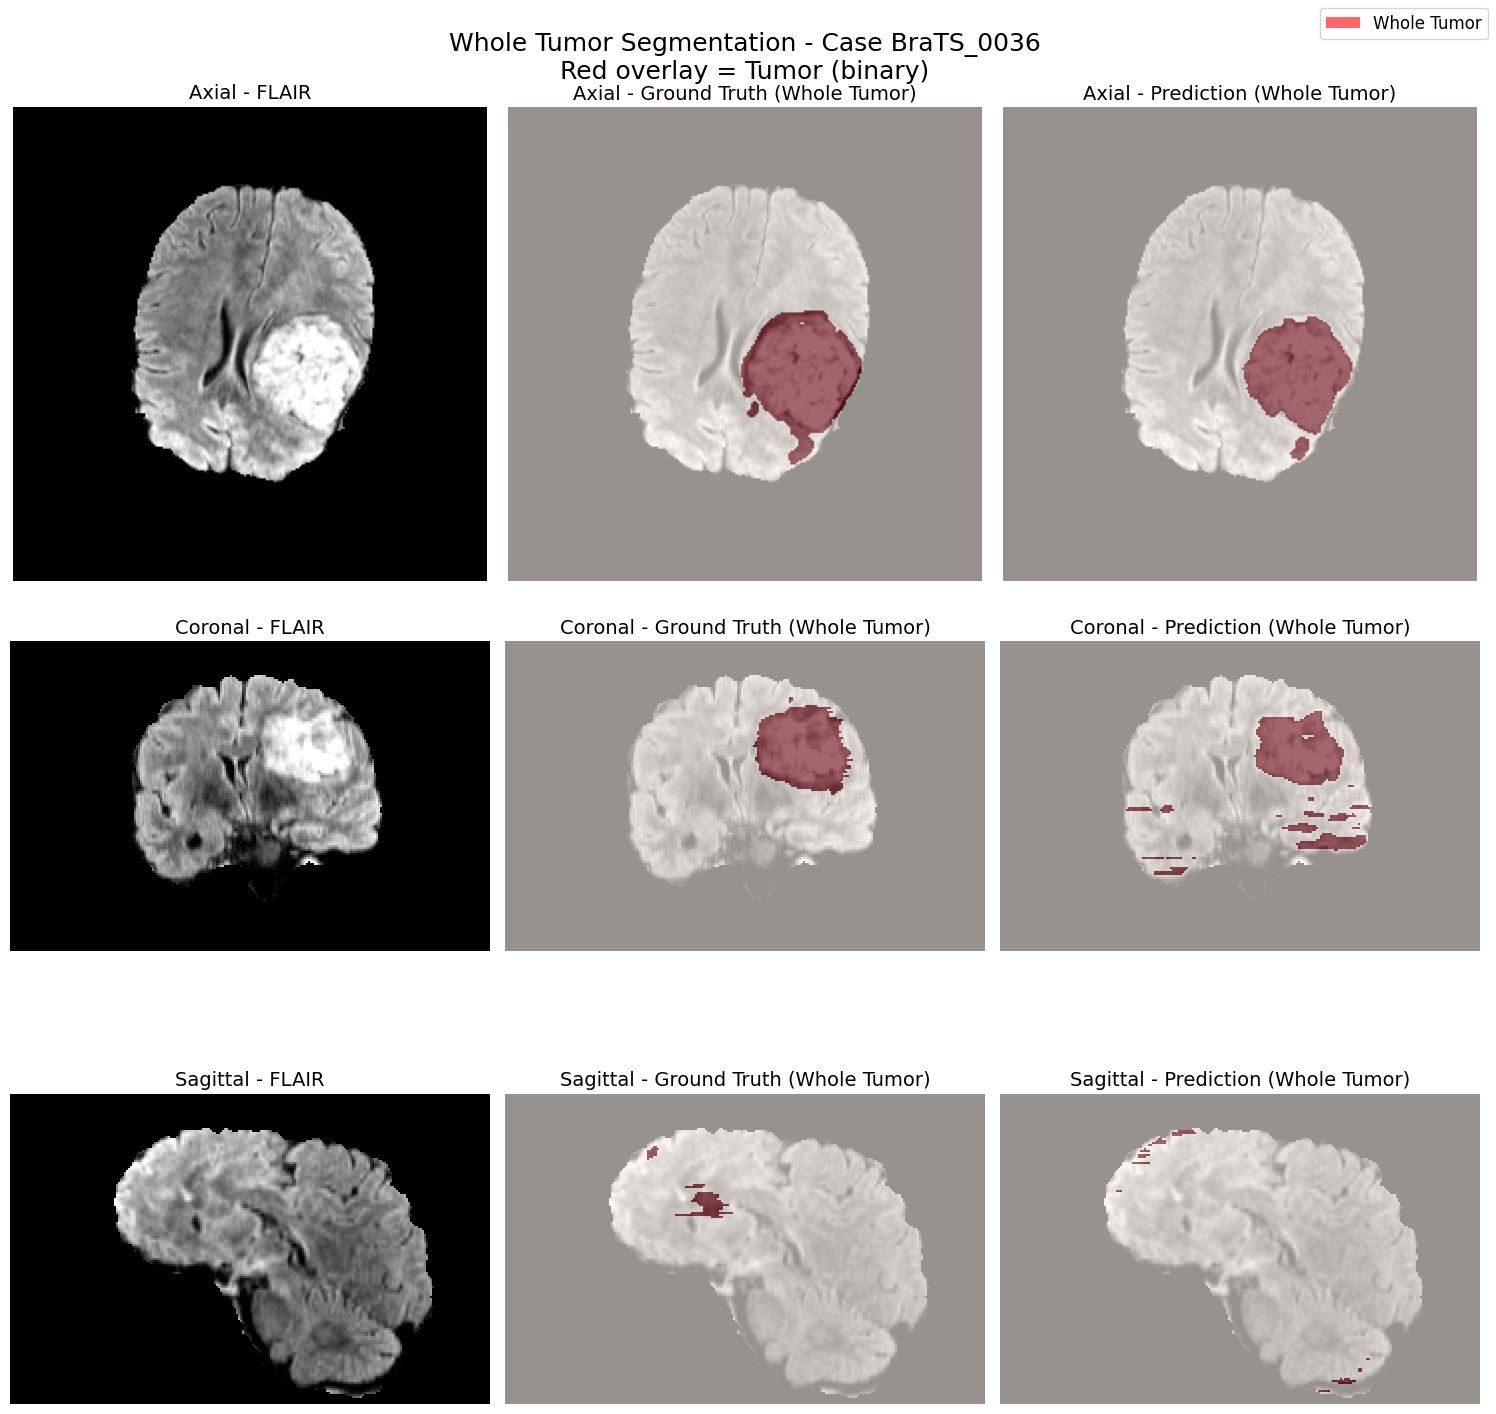

In [32]:
from pathlib import Path

# Settings
CASE_ID = "BraTS_0036"  # Change to any test case you want to visualize

# Directories
FLAIR_DIR = "/content/test_gt/imagesTs"  # Folder with BraTS_XXXX_0003.nii.gz (FLAIR)
GT_DIR = "/content/test_gt/gt_labels"
PR_DIR = "/content/test_preds_flair_only"       # FLAIR-only predictions

# Load FLAIR (background)
flair_path = os.path.join(FLAIR_DIR, f"{CASE_ID}_0003.nii.gz")
flair_nii = nib.load(flair_path)
flair_data = flair_nii.get_fdata()

# Load GT and Prediction
gt = nib.load(os.path.join(GT_DIR, f"{CASE_ID}.nii.gz")).get_fdata().astype(np.uint8)
pr = nib.load(os.path.join(PR_DIR, f"{CASE_ID}.nii.gz")).get_fdata().astype(np.uint8)

# Whole Tumor binary masks
gt_wt = (gt > 0).astype(np.uint8)   # Any tumor label
pr_wt = (pr > 0).astype(np.uint8)

# Normalize FLAIR for display
p2, p98 = np.percentile(flair_data[flair_data > 0], (2, 98))
flair_disp = np.clip((flair_data - p2) / (p98 - p2), 0, 1)

# Find best axial slice (max tumor area)
tumor_area_per_slice = np.sum(gt_wt, axis=(0, 1))
best_slice = np.argmax(tumor_area_per_slice)

# Plot: 3 views (Axial, Coronal, Sagittal) with GT and Prediction
views = [
    ("Axial", best_slice, flair_disp[:, :, best_slice], gt_wt[:, :, best_slice], pr_wt[:, :, best_slice]),
    ("Coronal", flair_data.shape[1]//2, flair_disp[:, flair_data.shape[1]//2, :], gt_wt[:, flair_data.shape[1]//2, :], pr_wt[:, flair_data.shape[1]//2, :]),
    ("Sagittal", flair_data.shape[0]//2, flair_disp[flair_data.shape[0]//2, :, :], gt_wt[flair_data.shape[0]//2, :, :], pr_wt[flair_data.shape[0]//2, :, :]),
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, (view_name, sl_idx, bg, gt_mask, pr_mask) in enumerate(views):
    # Background (FLAIR)
    axes[row, 0].imshow(bg.T, cmap="gray", origin="lower")
    axes[row, 0].set_title(f"{view_name} - FLAIR", fontsize=14)
    axes[row, 0].axis("off")

    # Ground Truth (red overlay)
    axes[row, 1].imshow(bg.T, cmap="gray", origin="lower")
    axes[row, 1].imshow(gt_mask.T, cmap="Reds", alpha=0.6, vmin=0, vmax=1, origin="lower")
    axes[row, 1].set_title(f"{view_name} - Ground Truth (Whole Tumor)", fontsize=14)
    axes[row, 1].axis("off")

    # Prediction (red overlay)
    axes[row, 2].imshow(bg.T, cmap="gray", origin="lower")
    axes[row, 2].imshow(pr_mask.T, cmap="Reds", alpha=0.6, vmin=0, vmax=1, origin="lower")
    axes[row, 2].set_title(f"{view_name} - Prediction (Whole Tumor)", fontsize=14)
    axes[row, 2].axis("off")

plt.suptitle(f"Whole Tumor Segmentation - Case {CASE_ID}\n"
             "Red overlay = Tumor (binary)", fontsize=18, y=0.98)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="red", alpha=0.6, label="Whole Tumor")]
fig.legend(handles=legend_elements, loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()